* Urbansound8K dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. 
* Random sample of 899 snoring wave files are added to the Urbansound8K set 
* This project is inspired by https://github.com/aqibsaeed/Urban-Sound-Classification/blob/master/Convolutional%20Neural%20Network.ipynb

In [11]:
# #Librosa is a library that is used for analyzing the behavior of audio
#!pip install librosa

In [8]:
#pip install tensorflow[and-cuda] #gast-0.4.0 keras-2.13.1 tensorboard-2.13.0 tensorflow-2.13.1 tensorflow-estimator-2.13.0

In [7]:
#pip install tensorflow

In [33]:
import glob, os, pickle
import numpy as np
import tensorflow as tf
import joblib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc
import matplotlib.pyplot as plt

import pandas as pd
from matplotlib import pylab
from pylab import *

import tensorflow as tf
import keras
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation,Flatten
from keras.layers import GRU, LSTM # CuDNNGRU, CuDNNLSTM, Activation
from keras.preprocessing.sequence import pad_sequences

import librosa
import librosa.display
import IPython.display as ipd

import warnings
warnings.filterwarnings("ignore")

In [2]:
import keras
keras.__version__

'2.15.0'

In [3]:
def extract_features(file_name):
    X, sample_rate = librosa.load(file_name) #extract first 2 sec data
    stft = np.abs(librosa.stft(X)) #signal in the time-frequency domain by computing discrete Fourier transforms 
    mfccs = np.array(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=8).T) #Mel-frequency cepstral coefficients
    chroma = np.array(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T) #chromagram from a waveform
    mel = np.array(librosa.feature.melspectrogram(y=X, sr=sample_rate).T) #melspectrogram()
    
    #For each sub-band of spectrogram, the energy contrast is estimated by 
    #comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). 
    #High contrast values generally correspond to clear, narrow-band signals, 
    #while low contrast values correspond to broad-band noise    
    contrast = np.array(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T)    
    
    tonnetz = np.array(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T) #get tonal centroid features
    
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    ignored = []    
    features, labels = np.empty((0,161)), np.empty(0)
    for sub_dir in sub_dirs:        
        print(sub_dir)
        for fn in tqdm(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))):            
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_features(fn)
                ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                #ext_features may have different rows
                
                features = np.vstack([features,ext_features])
                
                #each wave file contributes mfccs.shape[0]/172 rows of data with the same label  
                if sub_dir == "fold11":
                    l = ["10"] * (mfccs.shape[0]) 
                    labels = np.append(labels, l)
                else:
                    l = [fn.split('-')[1]] * (mfccs.shape[0]) 
                    labels = np.append(labels, l)
            except:
                print(f"{fn} is not proccessed.")
                ignored.append(file_ext)
                pass
            
        print(features.shape, labels.shape)
            
    #pickle.dump((features, labels), open(f"./sound_pkl/{sub_dir}.pkl", "wb"))           
    return features, labels, ignored


In [9]:
filename = "UrbanSound8K/audio/fold1/7061-6-0-0.wav"
# plt.figure(figsize=(14,5))
ipd.Audio(filename)

# random select 900 sample waves from 2500_Annotated_Snoring to UrbanSound8K  

In [13]:
snoring_files = os.listdir('../2500_Annotated_Snoring/')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../2500_Annotated_Snoring/'

In [15]:
len(snoring_files)

2500

In [18]:
np.random.seed(1234)
snoring_sample = np.random.choice(snoring_files, 900,replace = False)

In [20]:
print(len(snoring_sample))
snoring_sample[:4]

900


array(['190930_422_st12_Snoring_2537_1.wav',
       '190807_353_st12_Snoring_1715_1.wav',
       '190711_301_st12_Snoring_1004_1.wav',
       '190419_165_st12_Snoring_27_1.wav'], dtype='<U34')

In [27]:
for i in tqdm(snoring_sample):
    os.system(f"cp ../2500_Annotated_Snoring/{i} ./UrbanSound8K/audio/fold11/") 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 433.68it/s]


In [14]:
snore_lst = os.listdir("./UrbanSound8K/audio/fold11/")

FileNotFoundError: [WinError 3] The system cannot find the path specified: './UrbanSound8K/audio/fold11/'

In [8]:
snore_lst[0]

'190903_370_st12_Snoring_1942_1.wav'

In [17]:
mfccs,chroma,mel,contrast,tonnetz = extract_features("./UrbanSound8K/audio/fold1/99180-9-0-0.wav")

In [18]:
mfccs.shape

(173, 8)

In [19]:
chroma.shape

(173, 12)

In [20]:
ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])

In [21]:
ext_features.shape

(173, 161)

In [22]:
features = np.empty((0,161))

In [23]:
mfccs.shape[0]

173

In [25]:
parent_dir = 'UrbanSound8K/audio'

#add fold11 for snoring sound files, 800 random sample out of 3000 
sub_dirs = ["fold1", 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

In [26]:
# try:
#     labels = np.load('labels.npy')
#     features = np.load('features.npy')
#     print("Features and labels found!")
# except:
print("Extracting features...")

features, labels, ignored = parse_audio_files(parent_dir,sub_dirs)

Extracting features...
fold1


  0%|          | 0/873 [00:00<?, ?it/s]

 96%|█████████▌| 835/873 [05:01<00:08,  4.56it/s]

UrbanSound8K/audio\fold1\87275-1-1-0.wav is not proccessed.


100%|██████████| 873/873 [05:12<00:00,  2.79it/s]


(137008, 161) (137008,)
fold2


100%|██████████| 888/888 [04:41<00:00,  3.16it/s]


(273024, 161) (273024,)
fold3


100%|██████████| 925/925 [06:16<00:00,  2.45it/s]


(419988, 161) (419988,)
fold4


100%|██████████| 990/990 [07:00<00:00,  2.36it/s]


(573006, 161) (573006,)
fold5


100%|██████████| 936/936 [07:17<00:00,  2.14it/s]


(716871, 161) (716871,)
fold6


100%|██████████| 823/823 [07:18<00:00,  1.88it/s]


(845002, 161) (845002,)
fold7


100%|██████████| 838/838 [08:09<00:00,  1.71it/s]


(977621, 161) (977621,)
fold8


100%|██████████| 806/806 [08:18<00:00,  1.62it/s]


(1102553, 161) (1102553,)
fold9


100%|██████████| 816/816 [09:00<00:00,  1.51it/s]


(1231238, 161) (1231238,)
fold10


100%|██████████| 837/837 [09:46<00:00,  1.43it/s]

(1362691, 161) (1362691,)


In [27]:
with open('features_new.npy', 'wb') as f1:
    np.save(f1,features)
with open('labels_new.npy', 'wb') as f2:
    np.save(f2, labels)
with open('ignores_new.npy', 'wb') as f3:
    np.save(f3, ignored)

In [28]:
features = np.load("features_new.npy")
labels = np.load("labels_new.npy")

In [30]:
features.shape

(1362691, 161)

In [3]:
# cast label from string to float
labels = labels.astype(float)

In [4]:
# split the extracted features and labels
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=0, stratify=labels)

#scale the features
sc = StandardScaler()
sc.fit(features)

#transform the features
X_train = sc.transform(train_x)
X_val = sc.transform(test_x)

In [39]:
sc=StandardScaler()
sc.fit(features)

StandardScaler()

In [38]:
sc

''

In [40]:
dump(sc, 'std_scaler.bin', compress=True)

NameError: name 'dump' is not defined

In [41]:
sc = joblib.load('std_scaler.bin')

FileNotFoundError: [Errno 2] No such file or directory: 'std_scaler.bin'

In [29]:
type(X_train)

numpy.ndarray

In [30]:
X_val.shape

(285518, 161)

In [31]:
num_labels = 11
num_batch_size = 20000
num_epochs = 100 #can be bigger

In [32]:
X_train.shape[1]

161

In [33]:
#Base
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

best_model_weights = './model_wt/base_mode_11cls'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    mode = 'min',
    save_weights_only = False,
    save_freq='epoch')

callbacks = [checkpoint]

model.compile(optimizer = 'adam', #alternative "SGD"
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])          
    

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               41472     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               51400     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [35]:
history = model.fit(
    X_train,
    train_y,
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_data = (X_val, test_y),
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/100
57/58 [============================>.] - ETA: 0s - loss: 1.8047 - accuracy: 0.3834
Epoch 1: val_loss improved from inf to 1.22560, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 83ms/step - loss: 1.8040 - accuracy: 0.3837 - val_loss: 1.2256 - val_accuracy: 0.6026
Epoch 2/100
57/58 [============================>.] - ETA: 0s - loss: 1.2679 - accuracy: 0.5833
Epoch 2: val_loss improved from 1.22560 to 0.97679, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 1.2677 - accuracy: 0.5834 - val_loss: 0.9768 - val_accuracy: 0.6819
Epoch 3/100
57/58 [============================>.] - ETA: 0s - loss: 1.0838 - accuracy: 0.6464
Epoch 3: val_loss improved from 0.97679 to 0.83991, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 80ms/step - loss: 1.0836 - accuracy: 0.6465 - val_loss: 0.8399 - val_accuracy: 0.7261
Epoch 4/100
57/58 [============================>.] - ETA: 0s - loss: 0.9720 - accuracy: 0.6826
Epoch 4: val_loss improved from 0.83991 to 0.75712, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.9720 - accuracy: 0.6826 - val_loss: 0.7571 - val_accuracy: 0.7543
Epoch 5/100
57/58 [============================>.] - ETA: 0s - loss: 0.8980 - accuracy: 0.7078
Epoch 5: val_loss improved from 0.75712 to 0.69566, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.8980 - accuracy: 0.7078 - val_loss: 0.6957 - val_accuracy: 0.7735
Epoch 6/100
57/58 [============================>.] - ETA: 0s - loss: 0.8430 - accuracy: 0.7251
Epoch 6: val_loss improved from 0.69566 to 0.65138, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.8429 - accuracy: 0.7251 - val_loss: 0.6514 - val_accuracy: 0.7882
Epoch 7/100
57/58 [============================>.] - ETA: 0s - loss: 0.7988 - accuracy: 0.7395
Epoch 7: val_loss improved from 0.65138 to 0.61270, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.7988 - accuracy: 0.7395 - val_loss: 0.6127 - val_accuracy: 0.8003
Epoch 8/100
57/58 [============================>.] - ETA: 0s - loss: 0.7628 - accuracy: 0.7512
Epoch 8: val_loss improved from 0.61270 to 0.58189, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 75ms/step - loss: 0.7628 - accuracy: 0.7511 - val_loss: 0.5819 - val_accuracy: 0.8093
Epoch 9/100
57/58 [============================>.] - ETA: 0s - loss: 0.7343 - accuracy: 0.7603
Epoch 9: val_loss improved from 0.58189 to 0.55972, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.7343 - accuracy: 0.7603 - val_loss: 0.5597 - val_accuracy: 0.8173
Epoch 10/100
57/58 [============================>.] - ETA: 0s - loss: 0.7093 - accuracy: 0.7683
Epoch 10: val_loss improved from 0.55972 to 0.53655, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 79ms/step - loss: 0.7093 - accuracy: 0.7683 - val_loss: 0.5366 - val_accuracy: 0.8244
Epoch 11/100
57/58 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.7745
Epoch 11: val_loss improved from 0.53655 to 0.51890, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.6887 - accuracy: 0.7745 - val_loss: 0.5189 - val_accuracy: 0.8305
Epoch 12/100
57/58 [============================>.] - ETA: 0s - loss: 0.6710 - accuracy: 0.7809
Epoch 12: val_loss improved from 0.51890 to 0.50248, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.6709 - accuracy: 0.7809 - val_loss: 0.5025 - val_accuracy: 0.8359
Epoch 13/100
57/58 [============================>.] - ETA: 0s - loss: 0.6535 - accuracy: 0.7863
Epoch 13: val_loss improved from 0.50248 to 0.48889, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 75ms/step - loss: 0.6535 - accuracy: 0.7863 - val_loss: 0.4889 - val_accuracy: 0.8397
Epoch 14/100
57/58 [============================>.] - ETA: 0s - loss: 0.6410 - accuracy: 0.7903
Epoch 14: val_loss improved from 0.48889 to 0.47626, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.6409 - accuracy: 0.7903 - val_loss: 0.4763 - val_accuracy: 0.8433
Epoch 15/100
57/58 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.7948
Epoch 15: val_loss improved from 0.47626 to 0.46409, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.6270 - accuracy: 0.7948 - val_loss: 0.4641 - val_accuracy: 0.8477
Epoch 16/100
57/58 [============================>.] - ETA: 0s - loss: 0.6154 - accuracy: 0.7982
Epoch 16: val_loss improved from 0.46409 to 0.45416, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 79ms/step - loss: 0.6154 - accuracy: 0.7982 - val_loss: 0.4542 - val_accuracy: 0.8503
Epoch 17/100
57/58 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.8021
Epoch 17: val_loss improved from 0.45416 to 0.44480, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 85ms/step - loss: 0.6049 - accuracy: 0.8021 - val_loss: 0.4448 - val_accuracy: 0.8531
Epoch 18/100
57/58 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.8050
Epoch 18: val_loss improved from 0.44480 to 0.43602, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.5951 - accuracy: 0.8050 - val_loss: 0.4360 - val_accuracy: 0.8568
Epoch 19/100
57/58 [============================>.] - ETA: 0s - loss: 0.5875 - accuracy: 0.8076
Epoch 19: val_loss improved from 0.43602 to 0.42844, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 75ms/step - loss: 0.5875 - accuracy: 0.8076 - val_loss: 0.4284 - val_accuracy: 0.8583
Epoch 20/100
57/58 [============================>.] - ETA: 0s - loss: 0.5794 - accuracy: 0.8102
Epoch 20: val_loss improved from 0.42844 to 0.42071, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 75ms/step - loss: 0.5795 - accuracy: 0.8102 - val_loss: 0.4207 - val_accuracy: 0.8606
Epoch 21/100
57/58 [============================>.] - ETA: 0s - loss: 0.5720 - accuracy: 0.8124
Epoch 21: val_loss improved from 0.42071 to 0.41543, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 75ms/step - loss: 0.5719 - accuracy: 0.8124 - val_loss: 0.4154 - val_accuracy: 0.8623
Epoch 22/100
57/58 [============================>.] - ETA: 0s - loss: 0.5653 - accuracy: 0.8141
Epoch 22: val_loss improved from 0.41543 to 0.40935, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.5654 - accuracy: 0.8141 - val_loss: 0.4093 - val_accuracy: 0.8643
Epoch 23/100
57/58 [============================>.] - ETA: 0s - loss: 0.5592 - accuracy: 0.8167
Epoch 23: val_loss improved from 0.40935 to 0.40249, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.5593 - accuracy: 0.8167 - val_loss: 0.4025 - val_accuracy: 0.8663
Epoch 24/100
57/58 [============================>.] - ETA: 0s - loss: 0.5531 - accuracy: 0.8185
Epoch 24: val_loss improved from 0.40249 to 0.39799, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 81ms/step - loss: 0.5531 - accuracy: 0.8185 - val_loss: 0.3980 - val_accuracy: 0.8678
Epoch 25/100
57/58 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.8200
Epoch 25: val_loss improved from 0.39799 to 0.39334, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5480 - accuracy: 0.8200 - val_loss: 0.3933 - val_accuracy: 0.8689
Epoch 26/100
57/58 [============================>.] - ETA: 0s - loss: 0.5417 - accuracy: 0.8221
Epoch 26: val_loss improved from 0.39334 to 0.38687, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.5417 - accuracy: 0.8220 - val_loss: 0.3869 - val_accuracy: 0.8717
Epoch 27/100
57/58 [============================>.] - ETA: 0s - loss: 0.5379 - accuracy: 0.8232
Epoch 27: val_loss improved from 0.38687 to 0.38389, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 75ms/step - loss: 0.5379 - accuracy: 0.8232 - val_loss: 0.3839 - val_accuracy: 0.8727
Epoch 28/100
57/58 [============================>.] - ETA: 0s - loss: 0.5323 - accuracy: 0.8250
Epoch 28: val_loss improved from 0.38389 to 0.37899, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 78ms/step - loss: 0.5323 - accuracy: 0.8250 - val_loss: 0.3790 - val_accuracy: 0.8740
Epoch 29/100
57/58 [============================>.] - ETA: 0s - loss: 0.5288 - accuracy: 0.8266
Epoch 29: val_loss improved from 0.37899 to 0.37517, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.5287 - accuracy: 0.8266 - val_loss: 0.3752 - val_accuracy: 0.8749
Epoch 30/100
57/58 [============================>.] - ETA: 0s - loss: 0.5247 - accuracy: 0.8279
Epoch 30: val_loss improved from 0.37517 to 0.37245, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 79ms/step - loss: 0.5247 - accuracy: 0.8279 - val_loss: 0.3724 - val_accuracy: 0.8763
Epoch 31/100
57/58 [============================>.] - ETA: 0s - loss: 0.5213 - accuracy: 0.8290
Epoch 31: val_loss improved from 0.37245 to 0.36817, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 81ms/step - loss: 0.5212 - accuracy: 0.8290 - val_loss: 0.3682 - val_accuracy: 0.8773
Epoch 32/100
57/58 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.8294
Epoch 32: val_loss improved from 0.36817 to 0.36529, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5186 - accuracy: 0.8294 - val_loss: 0.3653 - val_accuracy: 0.8790
Epoch 33/100
57/58 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.8311
Epoch 33: val_loss improved from 0.36529 to 0.36164, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5150 - accuracy: 0.8311 - val_loss: 0.3616 - val_accuracy: 0.8794
Epoch 34/100
57/58 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.8320
Epoch 34: val_loss improved from 0.36164 to 0.35824, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5106 - accuracy: 0.8320 - val_loss: 0.3582 - val_accuracy: 0.8809
Epoch 35/100
57/58 [============================>.] - ETA: 0s - loss: 0.5087 - accuracy: 0.8328
Epoch 35: val_loss improved from 0.35824 to 0.35554, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5087 - accuracy: 0.8327 - val_loss: 0.3555 - val_accuracy: 0.8817
Epoch 36/100
57/58 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.8341
Epoch 36: val_loss improved from 0.35554 to 0.35298, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5045 - accuracy: 0.8341 - val_loss: 0.3530 - val_accuracy: 0.8824
Epoch 37/100
57/58 [============================>.] - ETA: 0s - loss: 0.5024 - accuracy: 0.8349
Epoch 37: val_loss improved from 0.35298 to 0.35066, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.5024 - accuracy: 0.8349 - val_loss: 0.3507 - val_accuracy: 0.8834
Epoch 38/100
57/58 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.8357
Epoch 38: val_loss improved from 0.35066 to 0.34801, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 83ms/step - loss: 0.4999 - accuracy: 0.8357 - val_loss: 0.3480 - val_accuracy: 0.8839
Epoch 39/100
57/58 [============================>.] - ETA: 0s - loss: 0.4968 - accuracy: 0.8365
Epoch 39: val_loss improved from 0.34801 to 0.34519, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4968 - accuracy: 0.8365 - val_loss: 0.3452 - val_accuracy: 0.8851
Epoch 40/100
57/58 [============================>.] - ETA: 0s - loss: 0.4954 - accuracy: 0.8374
Epoch 40: val_loss improved from 0.34519 to 0.34347, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4955 - accuracy: 0.8374 - val_loss: 0.3435 - val_accuracy: 0.8853
Epoch 41/100
57/58 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.8379
Epoch 41: val_loss improved from 0.34347 to 0.34140, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4929 - accuracy: 0.8379 - val_loss: 0.3414 - val_accuracy: 0.8860
Epoch 42/100
57/58 [============================>.] - ETA: 0s - loss: 0.4911 - accuracy: 0.8387
Epoch 42: val_loss improved from 0.34140 to 0.33880, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4911 - accuracy: 0.8387 - val_loss: 0.3388 - val_accuracy: 0.8871
Epoch 43/100
57/58 [============================>.] - ETA: 0s - loss: 0.4884 - accuracy: 0.8399
Epoch 43: val_loss improved from 0.33880 to 0.33740, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4884 - accuracy: 0.8399 - val_loss: 0.3374 - val_accuracy: 0.8875
Epoch 44/100
57/58 [============================>.] - ETA: 0s - loss: 0.4871 - accuracy: 0.8404
Epoch 44: val_loss improved from 0.33740 to 0.33538, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4872 - accuracy: 0.8403 - val_loss: 0.3354 - val_accuracy: 0.8883
Epoch 45/100
57/58 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8404
Epoch 45: val_loss improved from 0.33538 to 0.33369, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 82ms/step - loss: 0.4857 - accuracy: 0.8404 - val_loss: 0.3337 - val_accuracy: 0.8884
Epoch 46/100
57/58 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.8414
Epoch 46: val_loss improved from 0.33369 to 0.33220, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4821 - accuracy: 0.8413 - val_loss: 0.3322 - val_accuracy: 0.8891
Epoch 47/100
57/58 [============================>.] - ETA: 0s - loss: 0.4791 - accuracy: 0.8427
Epoch 47: val_loss improved from 0.33220 to 0.32913, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4790 - accuracy: 0.8427 - val_loss: 0.3291 - val_accuracy: 0.8900
Epoch 48/100
57/58 [============================>.] - ETA: 0s - loss: 0.4793 - accuracy: 0.8424
Epoch 48: val_loss improved from 0.32913 to 0.32890, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.4792 - accuracy: 0.8424 - val_loss: 0.3289 - val_accuracy: 0.8902
Epoch 49/100
57/58 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.8435
Epoch 49: val_loss improved from 0.32890 to 0.32695, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4769 - accuracy: 0.8435 - val_loss: 0.3270 - val_accuracy: 0.8906
Epoch 50/100
57/58 [============================>.] - ETA: 0s - loss: 0.4755 - accuracy: 0.8434
Epoch 50: val_loss improved from 0.32695 to 0.32518, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4755 - accuracy: 0.8434 - val_loss: 0.3252 - val_accuracy: 0.8913
Epoch 51/100
57/58 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.8439
Epoch 51: val_loss improved from 0.32518 to 0.32447, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.4752 - accuracy: 0.8439 - val_loss: 0.3245 - val_accuracy: 0.8920
Epoch 52/100
57/58 [============================>.] - ETA: 0s - loss: 0.4728 - accuracy: 0.8450
Epoch 52: val_loss improved from 0.32447 to 0.32295, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 82ms/step - loss: 0.4727 - accuracy: 0.8450 - val_loss: 0.3229 - val_accuracy: 0.8922
Epoch 53/100
57/58 [============================>.] - ETA: 0s - loss: 0.4717 - accuracy: 0.8451
Epoch 53: val_loss improved from 0.32295 to 0.32054, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4716 - accuracy: 0.8451 - val_loss: 0.3205 - val_accuracy: 0.8928
Epoch 54/100
57/58 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.8460
Epoch 54: val_loss improved from 0.32054 to 0.31997, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4700 - accuracy: 0.8460 - val_loss: 0.3200 - val_accuracy: 0.8932
Epoch 55/100
57/58 [============================>.] - ETA: 0s - loss: 0.4685 - accuracy: 0.8461
Epoch 55: val_loss improved from 0.31997 to 0.31860, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4685 - accuracy: 0.8461 - val_loss: 0.3186 - val_accuracy: 0.8941
Epoch 56/100
57/58 [============================>.] - ETA: 0s - loss: 0.4670 - accuracy: 0.8465
Epoch 56: val_loss improved from 0.31860 to 0.31708, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4670 - accuracy: 0.8465 - val_loss: 0.3171 - val_accuracy: 0.8947
Epoch 57/100
57/58 [============================>.] - ETA: 0s - loss: 0.4664 - accuracy: 0.8467
Epoch 57: val_loss improved from 0.31708 to 0.31573, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4664 - accuracy: 0.8467 - val_loss: 0.3157 - val_accuracy: 0.8946
Epoch 58/100
57/58 [============================>.] - ETA: 0s - loss: 0.4648 - accuracy: 0.8473
Epoch 58: val_loss improved from 0.31573 to 0.31444, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4648 - accuracy: 0.8473 - val_loss: 0.3144 - val_accuracy: 0.8951
Epoch 59/100
57/58 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8482
Epoch 59: val_loss improved from 0.31444 to 0.31265, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 78ms/step - loss: 0.4626 - accuracy: 0.8482 - val_loss: 0.3127 - val_accuracy: 0.8959
Epoch 60/100
57/58 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.8479
Epoch 60: val_loss improved from 0.31265 to 0.31226, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 82ms/step - loss: 0.4625 - accuracy: 0.8479 - val_loss: 0.3123 - val_accuracy: 0.8958
Epoch 61/100
57/58 [============================>.] - ETA: 0s - loss: 0.4611 - accuracy: 0.8485
Epoch 61: val_loss improved from 0.31226 to 0.31108, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4611 - accuracy: 0.8485 - val_loss: 0.3111 - val_accuracy: 0.8967
Epoch 62/100
57/58 [============================>.] - ETA: 0s - loss: 0.4599 - accuracy: 0.8487
Epoch 62: val_loss improved from 0.31108 to 0.31068, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4599 - accuracy: 0.8487 - val_loss: 0.3107 - val_accuracy: 0.8963
Epoch 63/100
57/58 [============================>.] - ETA: 0s - loss: 0.4594 - accuracy: 0.8491
Epoch 63: val_loss improved from 0.31068 to 0.30914, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 77ms/step - loss: 0.4594 - accuracy: 0.8490 - val_loss: 0.3091 - val_accuracy: 0.8968
Epoch 64/100
57/58 [============================>.] - ETA: 0s - loss: 0.4579 - accuracy: 0.8496
Epoch 64: val_loss improved from 0.30914 to 0.30843, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.4579 - accuracy: 0.8496 - val_loss: 0.3084 - val_accuracy: 0.8974
Epoch 65/100
57/58 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.8501
Epoch 65: val_loss improved from 0.30843 to 0.30687, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4561 - accuracy: 0.8500 - val_loss: 0.3069 - val_accuracy: 0.8979
Epoch 66/100
57/58 [============================>.] - ETA: 0s - loss: 0.4559 - accuracy: 0.8498
Epoch 66: val_loss improved from 0.30687 to 0.30604, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4559 - accuracy: 0.8498 - val_loss: 0.3060 - val_accuracy: 0.8984
Epoch 67/100
57/58 [============================>.] - ETA: 0s - loss: 0.4552 - accuracy: 0.8504
Epoch 67: val_loss improved from 0.30604 to 0.30580, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 82ms/step - loss: 0.4552 - accuracy: 0.8504 - val_loss: 0.3058 - val_accuracy: 0.8979
Epoch 68/100
57/58 [============================>.] - ETA: 0s - loss: 0.4539 - accuracy: 0.8510
Epoch 68: val_loss improved from 0.30580 to 0.30470, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4539 - accuracy: 0.8510 - val_loss: 0.3047 - val_accuracy: 0.8986
Epoch 69/100
57/58 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8508
Epoch 69: val_loss improved from 0.30470 to 0.30396, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 78ms/step - loss: 0.4537 - accuracy: 0.8508 - val_loss: 0.3040 - val_accuracy: 0.8984
Epoch 70/100
57/58 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8518
Epoch 70: val_loss improved from 0.30396 to 0.30277, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4515 - accuracy: 0.8518 - val_loss: 0.3028 - val_accuracy: 0.8987
Epoch 71/100
57/58 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.8513
Epoch 71: val_loss did not improve from 0.30277
58/58 [==============================] - 4s 66ms/step - loss: 0.4517 - accuracy: 0.8513 - val_loss: 0.3028 - val_accuracy: 0.8993
Epoch 72/100
57/58 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.8518
Epoch 72: val_loss improved from 0.30277 to 0.30189, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4505 - accuracy: 0.8519 - val_loss: 0.3019 - val_accuracy: 0.8993
Epoch 73/100
57/58 [============================>.] - ETA: 0s - loss: 0.4506 - accuracy: 0.8521
Epoch 73: val_loss improved from 0.30189 to 0.30029, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4506 - accuracy: 0.8521 - val_loss: 0.3003 - val_accuracy: 0.9000
Epoch 74/100
57/58 [============================>.] - ETA: 0s - loss: 0.4492 - accuracy: 0.8523
Epoch 74: val_loss improved from 0.30029 to 0.29955, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4492 - accuracy: 0.8523 - val_loss: 0.2995 - val_accuracy: 0.9002
Epoch 75/100
57/58 [============================>.] - ETA: 0s - loss: 0.4486 - accuracy: 0.8526
Epoch 75: val_loss improved from 0.29955 to 0.29880, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 81ms/step - loss: 0.4485 - accuracy: 0.8526 - val_loss: 0.2988 - val_accuracy: 0.9002
Epoch 76/100
57/58 [============================>.] - ETA: 0s - loss: 0.4472 - accuracy: 0.8529
Epoch 76: val_loss improved from 0.29880 to 0.29796, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4472 - accuracy: 0.8529 - val_loss: 0.2980 - val_accuracy: 0.9011
Epoch 77/100
57/58 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8534
Epoch 77: val_loss improved from 0.29796 to 0.29794, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4465 - accuracy: 0.8534 - val_loss: 0.2979 - val_accuracy: 0.9013
Epoch 78/100
57/58 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.8536
Epoch 78: val_loss improved from 0.29794 to 0.29662, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4458 - accuracy: 0.8536 - val_loss: 0.2966 - val_accuracy: 0.9013
Epoch 79/100
57/58 [============================>.] - ETA: 0s - loss: 0.4462 - accuracy: 0.8532
Epoch 79: val_loss improved from 0.29662 to 0.29549, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4462 - accuracy: 0.8532 - val_loss: 0.2955 - val_accuracy: 0.9020
Epoch 80/100
57/58 [============================>.] - ETA: 0s - loss: 0.4436 - accuracy: 0.8539
Epoch 80: val_loss improved from 0.29549 to 0.29549, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4436 - accuracy: 0.8539 - val_loss: 0.2955 - val_accuracy: 0.9021
Epoch 81/100
57/58 [============================>.] - ETA: 0s - loss: 0.4433 - accuracy: 0.8537
Epoch 81: val_loss did not improve from 0.29549
58/58 [==============================] - 4s 66ms/step - loss: 0.4433 - accuracy: 0.8537 - val_loss: 0.2957 - val_accuracy: 0.9020
Epoch 82/100
57/58 [============================>.] - ETA: 0s - loss: 0.4409 - accuracy: 0.8549
Epoch 82: val_loss improved from 0.29549 to 0.29356, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4409 - accuracy: 0.8549 - val_loss: 0.2936 - val_accuracy: 0.9024
Epoch 83/100
57/58 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8548
Epoch 83: val_loss did not improve from 0.29356
58/58 [==============================] - 4s 67ms/step - loss: 0.4419 - accuracy: 0.8548 - val_loss: 0.2936 - val_accuracy: 0.9024
Epoch 84/100
57/58 [============================>.] - ETA: 0s - loss: 0.4415 - accuracy: 0.8549
Epoch 84: val_loss improved from 0.29356 to 0.29330, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 82ms/step - loss: 0.4415 - accuracy: 0.8549 - val_loss: 0.2933 - val_accuracy: 0.9022
Epoch 85/100
57/58 [============================>.] - ETA: 0s - loss: 0.4408 - accuracy: 0.8551
Epoch 85: val_loss improved from 0.29330 to 0.29240, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4408 - accuracy: 0.8551 - val_loss: 0.2924 - val_accuracy: 0.9029
Epoch 86/100
57/58 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.8552
Epoch 86: val_loss improved from 0.29240 to 0.29121, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4405 - accuracy: 0.8552 - val_loss: 0.2912 - val_accuracy: 0.9030
Epoch 87/100
57/58 [============================>.] - ETA: 0s - loss: 0.4387 - accuracy: 0.8556
Epoch 87: val_loss did not improve from 0.29121
58/58 [==============================] - 4s 67ms/step - loss: 0.4387 - accuracy: 0.8556 - val_loss: 0.2913 - val_accuracy: 0.9033
Epoch 88/100
57/58 [============================>.] - ETA: 0s - loss: 0.4377 - accuracy: 0.8560
Epoch 88: val_loss improved from 0.29121 to 0.28998, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4377 - accuracy: 0.8560 - val_loss: 0.2900 - val_accuracy: 0.9035
Epoch 89/100
57/58 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.8557
Epoch 89: val_loss improved from 0.28998 to 0.28984, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4389 - accuracy: 0.8557 - val_loss: 0.2898 - val_accuracy: 0.9033
Epoch 90/100
57/58 [============================>.] - ETA: 0s - loss: 0.4366 - accuracy: 0.8564
Epoch 90: val_loss improved from 0.28984 to 0.28938, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4366 - accuracy: 0.8564 - val_loss: 0.2894 - val_accuracy: 0.9037
Epoch 91/100
57/58 [============================>.] - ETA: 0s - loss: 0.4372 - accuracy: 0.8562
Epoch 91: val_loss improved from 0.28938 to 0.28892, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 78ms/step - loss: 0.4372 - accuracy: 0.8562 - val_loss: 0.2889 - val_accuracy: 0.9040
Epoch 92/100
57/58 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.8560
Epoch 92: val_loss improved from 0.28892 to 0.28821, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 80ms/step - loss: 0.4369 - accuracy: 0.8560 - val_loss: 0.2882 - val_accuracy: 0.9041
Epoch 93/100
57/58 [============================>.] - ETA: 0s - loss: 0.4356 - accuracy: 0.8568
Epoch 93: val_loss improved from 0.28821 to 0.28741, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 76ms/step - loss: 0.4356 - accuracy: 0.8568 - val_loss: 0.2874 - val_accuracy: 0.9045
Epoch 94/100
57/58 [============================>.] - ETA: 0s - loss: 0.4347 - accuracy: 0.8571
Epoch 94: val_loss did not improve from 0.28741
58/58 [==============================] - 4s 66ms/step - loss: 0.4347 - accuracy: 0.8571 - val_loss: 0.2877 - val_accuracy: 0.9038
Epoch 95/100
57/58 [============================>.] - ETA: 0s - loss: 0.4343 - accuracy: 0.8571
Epoch 95: val_loss improved from 0.28741 to 0.28694, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4343 - accuracy: 0.8571 - val_loss: 0.2869 - val_accuracy: 0.9047
Epoch 96/100
57/58 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.8573
Epoch 96: val_loss improved from 0.28694 to 0.28627, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4352 - accuracy: 0.8573 - val_loss: 0.2863 - val_accuracy: 0.9048
Epoch 97/100
57/58 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8572
Epoch 97: val_loss improved from 0.28627 to 0.28606, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4340 - accuracy: 0.8572 - val_loss: 0.2861 - val_accuracy: 0.9047
Epoch 98/100
57/58 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.8574
Epoch 98: val_loss improved from 0.28606 to 0.28546, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 77ms/step - loss: 0.4329 - accuracy: 0.8574 - val_loss: 0.2855 - val_accuracy: 0.9050
Epoch 99/100
57/58 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8573
Epoch 99: val_loss improved from 0.28546 to 0.28516, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 4s 78ms/step - loss: 0.4334 - accuracy: 0.8573 - val_loss: 0.2852 - val_accuracy: 0.9052
Epoch 100/100
57/58 [============================>.] - ETA: 0s - loss: 0.4320 - accuracy: 0.8578
Epoch 100: val_loss improved from 0.28516 to 0.28463, saving model to ./model_wt/base_mode_11cls
INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


INFO:tensorflow:Assets written to: ./model_wt/base_mode_11cls/assets


58/58 [==============================] - 5s 81ms/step - loss: 0.4319 - accuracy: 0.8578 - val_loss: 0.2846 - val_accuracy: 0.9052


In [86]:
model.save("./model/base_11cls")

INFO:tensorflow:Assets written to: ./model/base_11cls/assets


INFO:tensorflow:Assets written to: ./model/base_11cls/assets


In [2]:
model = tf.keras.models.load_model("./model/base_11cls")

2023-10-23 18:56:42.386090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 18:56:42.420104: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [87]:
#model.save_weights('./model_wt/base_mode_11cls')

In [85]:
# # Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('./model_wt/base_mode_11cls')

In [36]:
loss, acc = model.evaluate(X_val, test_y, verbose=2)
print("MLP model accuracy: {:5.2f}%".format(100 * acc)) #90.52%

8923/8923 - 8s - loss: 0.2846 - accuracy: 0.9052 - 8s/epoch - 842us/step
MLP model accuracy: 90.52%


In [37]:
#model.predict_classes(X_test)
predict_val=model.predict(X_val) 
classes_val=np.argmax(predict_val,axis=1)
len(classes_val)

8923/8923 [==============================] - 8s 900us/step


285518

In [66]:
classes_val[:2]

array([ 0, 10])

In [38]:
labels_=[int(i) for i in np.unique(test_y)]
labels_

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [39]:
conf_mat = confusion_matrix(test_y, classes_val, labels=labels_)
print("overall accuracy:", sum(conf_mat.diagonal())/sum(sum(conf_mat)))

overall accuracy: 0.9051653485944844


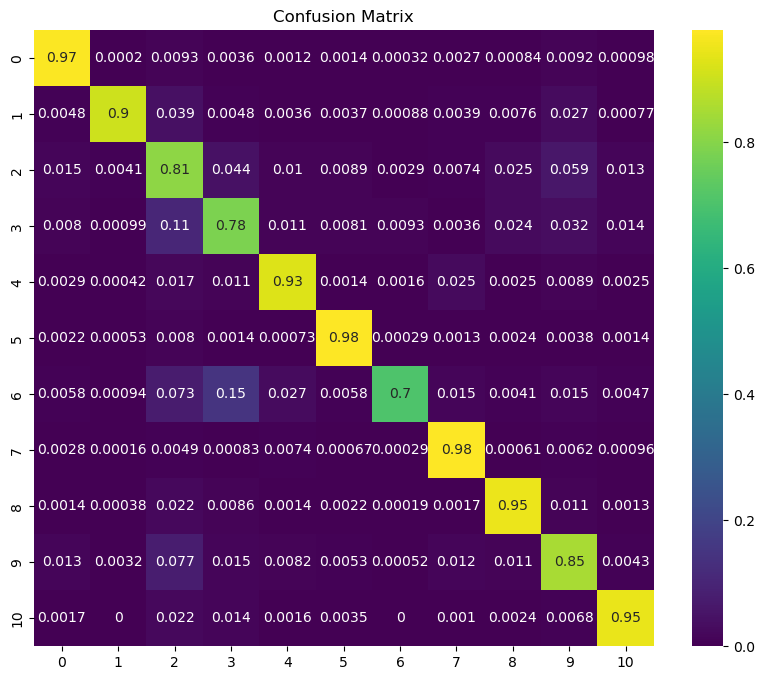

In [41]:
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat_norm, index = labels_,
                     columns = labels_)

plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

# check snoring OvR ROC plot

In [76]:
test_y_[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

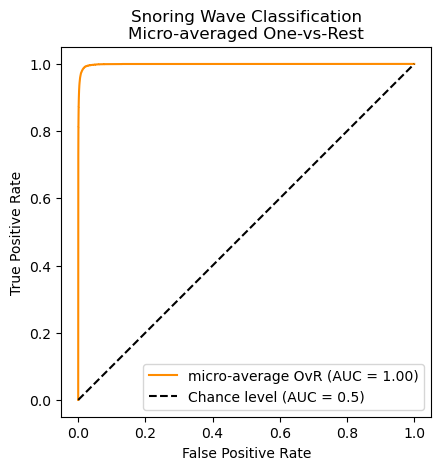

In [83]:
RocCurveDisplay.from_predictions(
    test_y_,
    predict_val[:,10],
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Snoring Wave Classification\nMicro-averaged One-vs-Rest")
plt.legend()
plt.show()

# plot model

In [90]:
#pip install pydot

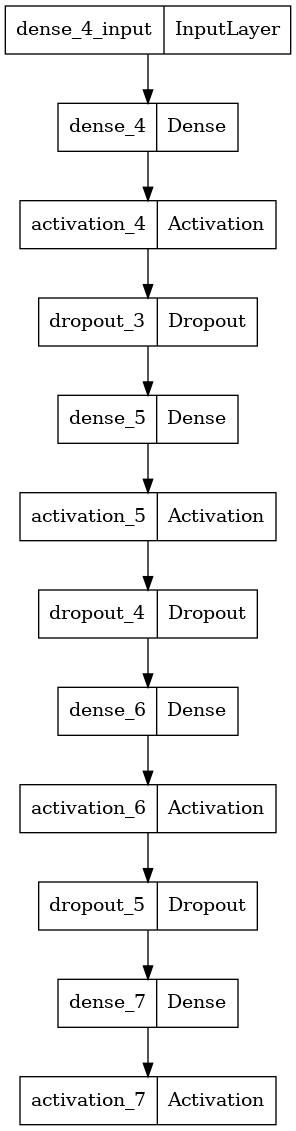

In [3]:
tf.keras.utils.plot_model(model)

# model inference 

In [18]:
cls_annotation = ['air_conditioner', 'car_horn', 'children_playing',
                  'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 
                  'siren', 'street_music', 'snoring']

In [2]:
# load model and scaler
model = tf.keras.models.load_model("./model/base_11cls")
sc = joblib.load('std_scaler.bin')

2023-10-27 12:45:13.079151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 12:45:13.304576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 12:45:13.304828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('snoring.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbvgjiy7r/assets


INFO:tensorflow:Assets written to: /tmp/tmpbvgjiy7r/assets
2023-10-25 11:52:48.197211: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-25 11:52:48.197248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-25 11:52:48.198161: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbvgjiy7r
2023-10-25 11:52:48.199384: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-25 11:52:48.199399: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpbvgjiy7r
2023-10-25 11:52:48.202905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-25 11:52:48.203591: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-10-25 11:52:48.236091: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

# Inference w/ tensorflow light runtime
# https://blog.paperspace.com/tensorflow-lite-raspberry-pi/

In [12]:
#!pip install tflite_runtime

In [13]:
from tflite_runtime.interpreter import Interpreter 

In [4]:
def processAudio(wav_file_path, sc):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(wav_file_path)
    features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
    #print(features.shape)
    return np.array(sc.transform(features))

In [7]:
features = processAudio("./UrbanSound8K/audio/fold1/99180-9-0-0.wav", sc)

In [8]:
features.shape

(173, 161)

In [14]:
model_path = "./snoring.tflite"

interpreter = Interpreter(model_path)
print("Model Loaded Successfully.")

interpreter.allocate_tensors()
row, col = interpreter.get_input_details()[0]['shape']
print(f"Wave festure Shape ({row} , {col})")

Model Loaded Successfully.
Wave festure Shape (1 , 161)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [15]:
# Get input and output tensors details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_dense_4_input:0', 'index': 0, 'shape': array([  1, 161], dtype=int32), 'shape_signature': array([ -1, 161], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([ 1, 11], dtype=int32), 'shape_signature': array([-1, 11], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [16]:
prob_out = np.empty((0,11))
for i in range(len(features)):
    interpreter.set_tensor(input_details[0]['index'], tf.cast(features[i,:].reshape(1, 161), tf.float32))
    interpreter.invoke()
    prob_out = np.vstack([prob_out, interpreter.get_tensor(output_details[0]['index'])[0]])
    cls_out = np.bincount(np.argmax(prob_out, axis = 1)).argmax()

In [19]:
print(f"The predicted class is {cls_out} as {cls_annotation[cls_out]}.")  

The predicted class is 9 as street_music.


# directly inference on TF model

In [72]:
def inferenceAudio(wav_file_path):
    global model, sc
    mfccs, chroma, mel, contrast, tonnetz = extract_features(wav_file_path)
    features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
    cls_prob = list(np.argmax(model.predict(np.array(sc.transform(features))), axis=1))
    major_cls = max(set(cls_prob), key = cls_prob.count)    
    print(f"The predicted class is {major_cls} as {cls_annotation[major_cls]}.") 

In [76]:
inferenceAudio("./UrbanSound8K/audio/fold1/99180-9-0-0.wav")

6/6 [==============================] - 0s 1ms/step
The predicted class is 9 as street_music.


In [1]:
filepath = "./UrbanSound8K/audio/fold1/99180-9-0-0.wav"
ipd.Audio(filepath)

NameError: name 'ipd' is not defined

In [ ]:
n_fft = 2048
hop_length = 512
window_type = 'hann'

spectrogram
